# Install libraries

In [2]:
# install libraries
!pip install catboost


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px
from IPython.display import display

# score metrics and splitting libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

# ML algorithms from sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor

# extreme algorithms
from xgboost import XGBRFRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# warning turn off
import warnings
warnings.filterwarnings('ignore')

In [3]:
#set display max column to see all column
pd.set_option("display.max_columns", None)
pd.get_option("display.max_columns")

#set display max column to see all column
pd.set_option("display.max_rows", 150)
pd.get_option("display.max_rows")

150

# Load Datasets

In [4]:
# load datasets

train = pd.read_csv('/kaggle/input/delays-data-cleaned/cleaned_train.csv')
test = pd.read_csv('/kaggle/input/delays-data-cleaned/cleaned_test.csv')

train.head()

,Weekday,Month_of_Year,Day_of_Month,Departure_State,Arrival_State,Flight_Cancelled,Departure_Delay,Arrival_Delay,Taxi_Out_Time,Taxi_In_Time,Flight_Diverted,Flight_Duration,Flight_Distance,Origin_Temperature,Destination_Temperature,Origin_Wind_Speed,Destination_Wind_Speed,Origin_Precipitation,Destination_Precipitation,Scheduled_Departure_Time_Minutes,Scheduled_Arrival_Time_Minutes,Actual_Departure_Time_Minutes
0,2,6,21,3,3,0,0.088687,-4.178483,16.0,5.0,0,23.0,110.0,13.279939,20.470690,18.045064,12.910265,0.0,0.0,736,784,736
1,3,1,5,22,50,0,13.027852,5.042185,34.0,5.0,0,36.0,119.0,17.816202,13.967273,21.606228,17.976362,0.0,0.1,1185,1255,1185
2,2,3,22,8,44,0,-1.802698,-0.206932,10.0,11.0,0,125.0,641.0,24.562566,14.509228,24.946489,22.630553,0.0,0.0,420,564,418
3,4,7,14,49,32,0,13.027852,14.006092,23.0,7.0,0,130.0,867.0,8.817992,10.866812,17.426336,17.401007,0.0,0.0,1290,1439,1293
4,1,5,30,4,4,0,-2.181755,-14.067374,10.0,5.0,0,58.0,417.0,9.360464,15.977111,19.001179,16.884960,0.0,0.0,470,555,468


We split the train, contains target variable, to train and validation to train and test models performance and accuracy.

In [5]:
# split train to train set and validation sets, use 75 - 25 % approach
# Shuffle the indices
indices = np.arange(len(train))
np.random.shuffle(indices)

# Define the split ratio
split_ratio = 0.75

# Calculate split indices
split_index = int(len(train) * split_ratio)

# Split the data
df_train = train.iloc[indices[:split_index], :]
df_test = train.iloc[indices[split_index:], :]

df_train.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)

print(f'Train size : {df_train.shape}')
print(f'Test size : {df_test.shape}')

Train size : (1065015, 22)
Test size : (355006, 22)


In [6]:
display(df_train.head())

print('*' * 70)
df_test.head()

,Weekday,Month_of_Year,Day_of_Month,Departure_State,Arrival_State,Flight_Cancelled,Departure_Delay,Arrival_Delay,Taxi_Out_Time,Taxi_In_Time,Flight_Diverted,Flight_Duration,Flight_Distance,Origin_Temperature,Destination_Temperature,Origin_Wind_Speed,Destination_Wind_Speed,Origin_Precipitation,Destination_Precipitation,Scheduled_Departure_Time_Minutes,Scheduled_Arrival_Time_Minutes,Actual_Departure_Time_Minutes
0,7,1,2,13,42,0,13.027852,91.948809,18.0,12.0,0,76.0,475.0,19.229204,19.681649,15.002575,18.397363,1.0,0.1,920,1081,1007
1,4,5,5,32,14,0,-10.003624,-0.022115,19.0,4.0,0,201.0,1649.0,21.473568,14.232638,23.840208,30.052482,0.0,0.0,1410,364,1400
2,1,1,24,13,13,0,-15.228318,-31.923391,9.0,11.0,0,39.0,174.0,13.989780,23.233300,13.069337,14.976108,0.0,0.0,1044,1120,1029
3,5,3,25,40,21,0,-4.765882,-1.951001,16.0,13.0,0,84.0,508.0,17.220238,12.356722,23.259623,15.954383,0.0,0.0,360,470,355
4,1,7,4,9,9,0,4.957858,27.341077,41.0,11.0,0,32.0,143.0,14.674150,16.720818,8.674904,15.053205,0.0,0.0,410,472,415


**********************************************************************


,Weekday,Month_of_Year,Day_of_Month,Departure_State,Arrival_State,Flight_Cancelled,Departure_Delay,Arrival_Delay,Taxi_Out_Time,Taxi_In_Time,Flight_Diverted,Flight_Duration,Flight_Distance,Origin_Temperature,Destination_Temperature,Origin_Wind_Speed,Destination_Wind_Speed,Origin_Precipitation,Destination_Precipitation,Scheduled_Departure_Time_Minutes,Scheduled_Arrival_Time_Minutes,Actual_Departure_Time_Minutes
0,4,5,5,17,9,0,4.120668,-0.337259,12.0,10.0,0,77.0,551.0,12.471617,17.377301,16.622701,23.547268,0.0,0.0,608,771,612
1,4,6,16,9,4,0,-1.137685,-7.231652,16.0,25.0,0,238.0,1947.0,15.951287,16.524377,26.246899,28.929832,0.1,0.0,515,620,514
2,6,2,5,37,13,0,-8.988411,-20.136562,13.0,13.0,0,110.0,632.0,18.383530,18.120799,19.688985,21.584726,0.0,0.0,873,960,864
3,2,5,31,49,4,0,-0.043584,-23.021921,10.0,2.0,0,117.0,908.0,16.086543,16.235452,23.938961,20.775763,0.0,0.0,545,697,545
4,7,4,10,5,44,0,36.197980,37.991190,11.0,22.0,0,124.0,862.0,21.432387,19.588187,20.799768,18.878903,0.0,0.0,700,915,736


# Parameter Tuning

When working with a large dataset like ours (1 million rows), finding the best parameters for regression models while ensuring efficient model training and evaluation cost to much computation and time.

To handle this issue we use **Sampling for Hyperparameter Tuning**. It means that instead of using the entire dataset for hyperparameter tuning, we can use a representative sample of data. This will significantly reduce computation time and allow us to perform thorough hyperparameter tuning.

In [7]:
# use 15% of the data for tuning
sample_size = int(0.15 * len(df_train))
df_sample = df_train.sample(n = sample_size, random_state = 42)

X_sample = df_sample.drop(columns=['Arrival_Delay'])
y_sample = df_sample['Arrival_Delay']

## Parameters for baseline models

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size = 0.3, random_state = 0)

X_train.shape

(111826, 21)

In [9]:
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error


# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


In [17]:
from hyperopt import hp

space = {
    'nthread': hp.uniform('nthread', 3, 10),
    'n_estimators': hp.choice('n_estimators', [500, 1000, 5000, 10000]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 50, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'min_split_gain': hp.uniform('min_split_gain', 0.0, 0.1),
    'min_child_weight': hp.uniform('min_child_weight', 0.0, 10.0),
    'silent': -1,
    'verbose': -1,
    'random_state': 42,
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart', 'rf'])
}

In [20]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error
from hyperopt import STATUS_OK

# Define the objective function
def objective(space):
    lgb_reg = LGBMRegressor(
        nthread=int(space['nthread']),
        n_estimators=int(space['n_estimators']),
        learning_rate=space['learning_rate'],
        num_leaves=int(space['num_leaves']),
        colsample_bytree=space['colsample_bytree'],
        subsample=space['subsample'],
        max_depth=int(space['max_depth']),
        reg_alpha=space['reg_alpha'],
        reg_lambda=space['reg_lambda'],
        min_split_gain=space['min_split_gain'],
        min_child_weight=space['min_child_weight'],
        silent=space['silent'],
        verbose=space['verbose'],
        random_state=space['random_state'],
        boosting_type=space['boosting_type'],  # Ensure boosting_type is included
        
        n_jobs=-1
    )
    
    lgb_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], 
            eval_metric='mape')
    
    pred = lgb_reg.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, pred)
    print("MAPE:", mape)
    
    return {'loss': mape, 'status': STATUS_OK}


In [21]:
%%time

# Create a Trials object to store information about the optimization process
trials = Trials()

# Run hyperparameter optimization
best_hyperparameters = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,  # Adjust max_evals as needed
            trials=trials)


MAPE:                                                  
90.86506459206275                                      
MAPE:                                                                           
34.34659971452381                                                               
MAPE:                                                                           
56.498675759860916                                                              
MAPE:                                                                           
71.35449371543667                                                               
MAPE:                                                                             
40.77866241902468                                                                 
MAPE:                                                                             
144.17268477274408                                                              
MAPE:                                                                   

In [10]:
print("The best hyperparameters are : ","\n")

print("Best hyperparameters:", best_hyperparameters)

The best hyperparameters are :  



NameError: name 'best_hyperparameters' is not defined

In [23]:
best_parameters = best_hyperparameters
best_parameters

{'boosting_type': 0,
 'colsample_bytree': 0.8083100557602823,
 'learning_rate': 0.5590257573381373,
 'max_depth': 8.0,
 'min_child_weight': 6.329915255850705,
 'min_split_gain': 0.01593297353431914,
 'n_estimators': 1,
 'nthread': 6.6516088270926605,
 'num_leaves': 38.0,
 'reg_alpha': 0.7801473610044566,
 'reg_lambda': 0.9168560003582829,
 'subsample': 0.560868988960792}

In [6]:
best_param = {'boosting_type': 'gbdt',
 'colsample_bytree': 0.8083100557602823,
 'learning_rate': 0.5590257573381373,
 'max_depth': 8,
 'min_child_weight': 6.329915255850705,
 'min_split_gain': 0.01593297353431914,
 'n_estimators': 1897,
 'nthread': 6.6516088270926605,
 'num_leaves': 38,
 'reg_alpha': 0.7801473610044566,
 'reg_lambda': 0.9168560003582829,
 'subsample': 0.560868988960792}



In [7]:
# test model with using big data
X_train = df_train.drop(columns=['Arrival_Delay'])
X_test = df_test.drop(columns=['Arrival_Delay'])
y_train = df_train['Arrival_Delay']
y_test = df_test['Arrival_Delay']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1065015, 21) (1065015,)
(355006, 21) (355006,)


In [8]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error

# Create the XGBRegressor model with the best parameters
lgb_reg = LGBMRegressor(**best_param)

# Train the model
lgb_reg.fit(X_train, y_train)

# Make predictions
pred = lgb_reg.predict(X_test)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, pred)

print('MAPE :', mape)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.283219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2954
[LightGBM] [Info] Number of data points in the train set: 1065015, number of used features: 19
[LightGBM] [Info] Start training from score 7.526520
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
MAPE : 11.423149321282697


In [9]:
%%time
# cross validation technique

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error

# Create the XGBRegressor model with the best parameters
lgb_reg1 = LGBMRegressor(**best_param)


# Define the K-Fold cross-validation strategy
kfold = KFold(n_splits=7, shuffle=True, random_state=42)

# Initialize lists to store evaluation scores
mape_scores = []

# Perform K-Fold Cross-Validation
for train_index, test_index in kfold.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Fit the XGBoost model on the training fold
    lgb_reg1.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_pred_val = lgb_reg1.predict(X_val_fold)

    # Calculate MAPE on the validation fold
    mape = mean_absolute_percentage_error(y_val_fold, y_pred_val)
    print(f'folds are working :  {mape} \n\n')
    mape_scores.append(mape)

# Calculate mean MAPE across all folds
mean_mape = sum(mape_scores) / len(mape_scores)
print("\n\nMean MAPE:", mean_mape)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.418523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2952
[LightGBM] [Info] Number of data points in the train set: 912870, number of used features: 19
[LightGBM] [Info] Start training from score 7.494467
folds are working :  10.009222601479387 


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.411945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2951
[LightGBM] [Info] Number of data points in the train set: 912870, number of used features: 19
[LightGBM] [Info] Start training from score 7.557387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
folds are working :  8.702862140119995 


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.419340 seconds.
You can set `force_col_wise=true` to remove the ov

In [10]:
lgb_reg1.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.8083100557602823,
 'importance_type': 'split',
 'learning_rate': 0.5590257573381373,
 'max_depth': 8,
 'min_child_samples': 20,
 'min_child_weight': 6.329915255850705,
 'min_split_gain': 0.01593297353431914,
 'n_estimators': 1897,
 'n_jobs': None,
 'num_leaves': 38,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.7801473610044566,
 'reg_lambda': 0.9168560003582829,
 'subsample': 0.560868988960792,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'nthread': 6.6516088270926605}

In [11]:

# Make predictions
pred = lgb_reg1.predict(X_test)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, pred)

print('MAPE :', mape)


MAPE : 9.244722254020147


In [14]:
# Ensure that test dataset has the same columns and order as the training dataset
test = test[X_train.columns]
display(test.head())

# Make predictions using the reduced feature set
submission = lgb_reg1.predict(test)

# Create a submission dataframe
submission_df = pd.DataFrame(submission, index=test.index, columns=['Arrival_Delay'])

# Save the submission dataframe to a CSV file
submission_df.to_csv('submission.csv', index = False)

# Display the first few rows of the submission
submission_df.head()


,Weekday,Month_of_Year,Day_of_Month,Departure_State,Arrival_State,Flight_Cancelled,Departure_Delay,Taxi_Out_Time,Taxi_In_Time,Flight_Diverted,Flight_Duration,Flight_Distance,Origin_Temperature,Destination_Temperature,Origin_Wind_Speed,Destination_Wind_Speed,Origin_Precipitation,Destination_Precipitation,Scheduled_Departure_Time_Minutes,Scheduled_Arrival_Time_Minutes,Actual_Departure_Time_Minutes
0,2,5,10,33,26,0,-1.297456,31.0,10.0,0,64.0,427.0,11.274087,16.012261,17.332261,24.629961,0.0,0.0,500,611,499
1,3,3,9,36,49,0,-1.932714,27.0,5.0,0,53.0,228.0,4.967302,18.358241,17.795975,15.307041,0.0,0.0,326,415,324
2,3,3,9,8,21,0,13.599264,16.0,5.0,0,134.0,1084.0,18.483917,16.467901,18.704558,17.468001,0.0,0.0,1011,1183,1025
3,5,4,15,44,5,0,12.887706,18.0,13.0,0,107.0,641.0,12.932652,18.790894,14.105251,25.659088,2.0,1.0,693,765,706
4,3,5,11,30,8,0,13.061360,18.0,14.0,0,125.0,937.0,18.982421,15.382372,22.579627,19.144705,0.0,0.0,907,1072,1057


,Arrival_Delay
0,-7.286015
1,5.903755
2,-0.705553
3,19.256847
4,95.546009


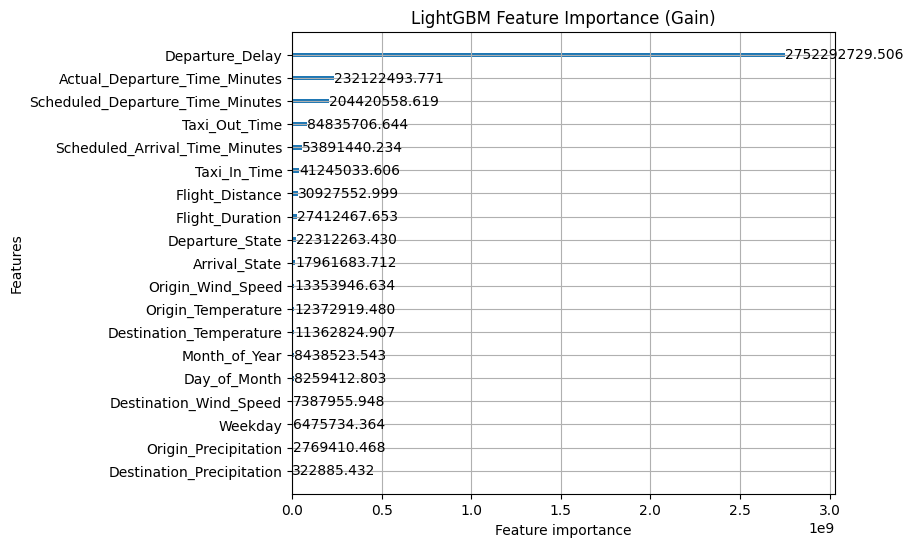

In [ ]:
import lightgbm as lgb

lgb.plot_importance(lgb_reg1, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

In [13]:
importances = lgb_reg1.feature_importance()
feature_names = X_train.columns

# Create a dataframe for feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the dataframe by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the importance scores
importance_df


AttributeError: 'LGBMRegressor' object has no attribute 'feature_importance'

### Feature selection

In [23]:
best_param_lgb = {'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.8083100557602823,
 'importance_type': 'split',
 'learning_rate': 0.5590257573381373,
 'max_depth': 8,
 'min_child_samples': 20,
 'min_child_weight': 6.329915255850705,
 'min_split_gain': 0.01593297353431914,
 'n_estimators': 1897,
 'n_jobs': -1,
 'num_leaves': 38,
 'reg_alpha': 0.7801473610044566,
 'reg_lambda': 0.9168560003582829,
 'subsample': 0.560868988960792,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'nthread': 6.6516088270926605}


In [27]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# Split the training data into train and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create a LightGBM dataset
train_data = lgb.Dataset(X_train_split, label=y_train_split)
valid_data = lgb.Dataset(X_val_split, label=y_val_split, reference=train_data)


# Train the model
model = lgb.train(best_param_lgb, train_data, valid_sets=[train_data, valid_data], num_boost_round=100)

# Get feature importances
importances = model.feature_importance()
feature_names = X_train.columns

# Create a dataframe for feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the dataframe by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the importance scores
importance_df


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=6.6516088270926605 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=6.6516088270926605 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2953
[LightGBM] [Info] Number of data points in the train set: 852012, number of used features: 19
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=6.6516088270926605 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Start training from score 7.439258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

,Feature,Importance
11,Flight_Distance,7679
18,Scheduled_Departure_Time_Minutes,7197
19,Scheduled_Arrival_Time_Minutes,7040
10,Flight_Duration,6251
20,Actual_Departure_Time_Minutes,6025
6,Departure_Delay,5425
3,Departure_State,5156
4,Arrival_State,4694
7,Taxi_Out_Time,3314
1,Month_of_Year,2495


In [28]:
# Select the top N features
top_n = 10
top_features = importance_df.head(top_n)['Feature']

# Reduce the dataset to the top N features
X_train_reduced = X_train[top_features]
X_test_reduced = df_test[top_features]


In [29]:
X_train_reduced.shape

(1065015, 10)

In [32]:
# Re-train the model using the selected features
X_train_split_reduced, X_val_split_reduced, y_train_split_reduced, y_val_split_reduced = train_test_split(X_train_reduced, y_train,
                                                                                                          test_size=0.2, random_state=42)

train_data_reduced = lgb.Dataset(X_train_split_reduced, label=y_train_split_reduced)
valid_data_reduced = lgb.Dataset(X_val_split_reduced, label=y_val_split_reduced, reference=train_data_reduced)

model_reduced = lgb.train(best_param_lgb, train_data_reduced, valid_sets=[train_data_reduced, valid_data_reduced],
                          num_boost_round=1000)


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=6.6516088270926605 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=6.6516088270926605 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1774
[LightGBM] [Info] Number of data points in the train set: 852012, number of used features: 10
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=6.6516088270926605 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Start training from score 7.439258


In [33]:

# Make predictions
pred_reduced = model_reduced.predict(X_test[X_train_split_reduced.columns])

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, pred_reduced)

print('MAPE :', mape)


MAPE : 20.09445022513382


In [ ]:
# Ensure that test dataset has the same columns and order as the training dataset
test = test[X_train_reduced.columns]
display(test.head())

# Make predictions using the reduced feature set
submission = model_reduced.predict(test)

# Create a submission dataframe
submission_df = pd.DataFrame(submission, index=test.index, columns=['Arrival_Delay'])

# Save the submission dataframe to a CSV file
submission_df.to_csv('submission.csv', index_label='id')

# Display the first few rows of the submission
submission_df.head()


# Create a submission file

In [1]:
# Ensure that test dataset has the same columns and order as the training dataset
test = test[X_train.columns]

# Make a prediction based on the test dataset
submission = lgb_reg1.predict(test)

# Create the submission dataframe
submission_df = pd.DataFrame(submission, index=test.index, columns=['Arrival_Delay'])

# Save the submission dataframe to a CSV file
submission_df.to_csv('submission_lgb.csv', index = False)


submission_df.head()

NameError: name 'test' is not defined